# Who Painted What? Artist Identification Model

This project has two differentiated parts. Firstly, it explores a dataset with information about famous artists and their paintings. Secondly, a predictive model is built to be able to identify the name of the author given a painting. 

## Table of contents
- [Importing Dataset and Libraries](#importing)
- [Analysis of the Data](#analysis)
    - [General Exploration and Plots](#exploration)
    - [Impact of Genre on Paintings](#genre)
    - [Impact of Nationality on Paintings](#nationality)
    - [Relationship between Nationality and Genre](#correlation)
- [Artist Predition Model](#prediction) (work in progress)

## Importing Dataset and Libraries <a name="exploration"></a>

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [214]:
artists = pd.read_csv('../art-history/datasets_130081_310927_artists.csv')

## Analysis of the Data <a name="analysis"></a>

### General Exploration and Plots <a name="exploration"></a>

In [215]:
artists.head()

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

In [216]:
artists.shape

(50, 8)

In [217]:
artists.dtypes

id              int64
name           object
years          object
genre          object
nationality    object
bio            object
wikipedia      object
paintings       int64
dtype: object

In [218]:
paintings_df = artists.drop(['id', 'genre', 'years', 'nationality', 'bio', 'wikipedia'], axis=1)
paintings_df_sorted = paintings_df.sort_values('paintings', ascending=False)
paintings_df_sorted.head()

name  paintings
8        Vincent van Gogh        877
30            Edgar Degas        702
13          Pablo Picasso        439
15  Pierre-Auguste Renoir        336
19         Albrecht Dürer        328

The above table shows the artists with the highest number of paintings. The first five positions correspond to Van Gogh, Degas, Picasso, Renoir and Dürer, respectively. 

In [219]:
paintings_df_sorted.tail()

name  paintings
48      Michelangelo         49
38      Paul Cezanne         47
41    Georges Seurat         43
39  Eugene Delacroix         31
49   Jackson Pollock         24

Similarly, the artists with the fewest paintings are, in this order, Pollock, Delacroix, Seurat, Cezanne and Michelangelo. In the following barplot we can observe the amount of paintings per artist in our data set. 

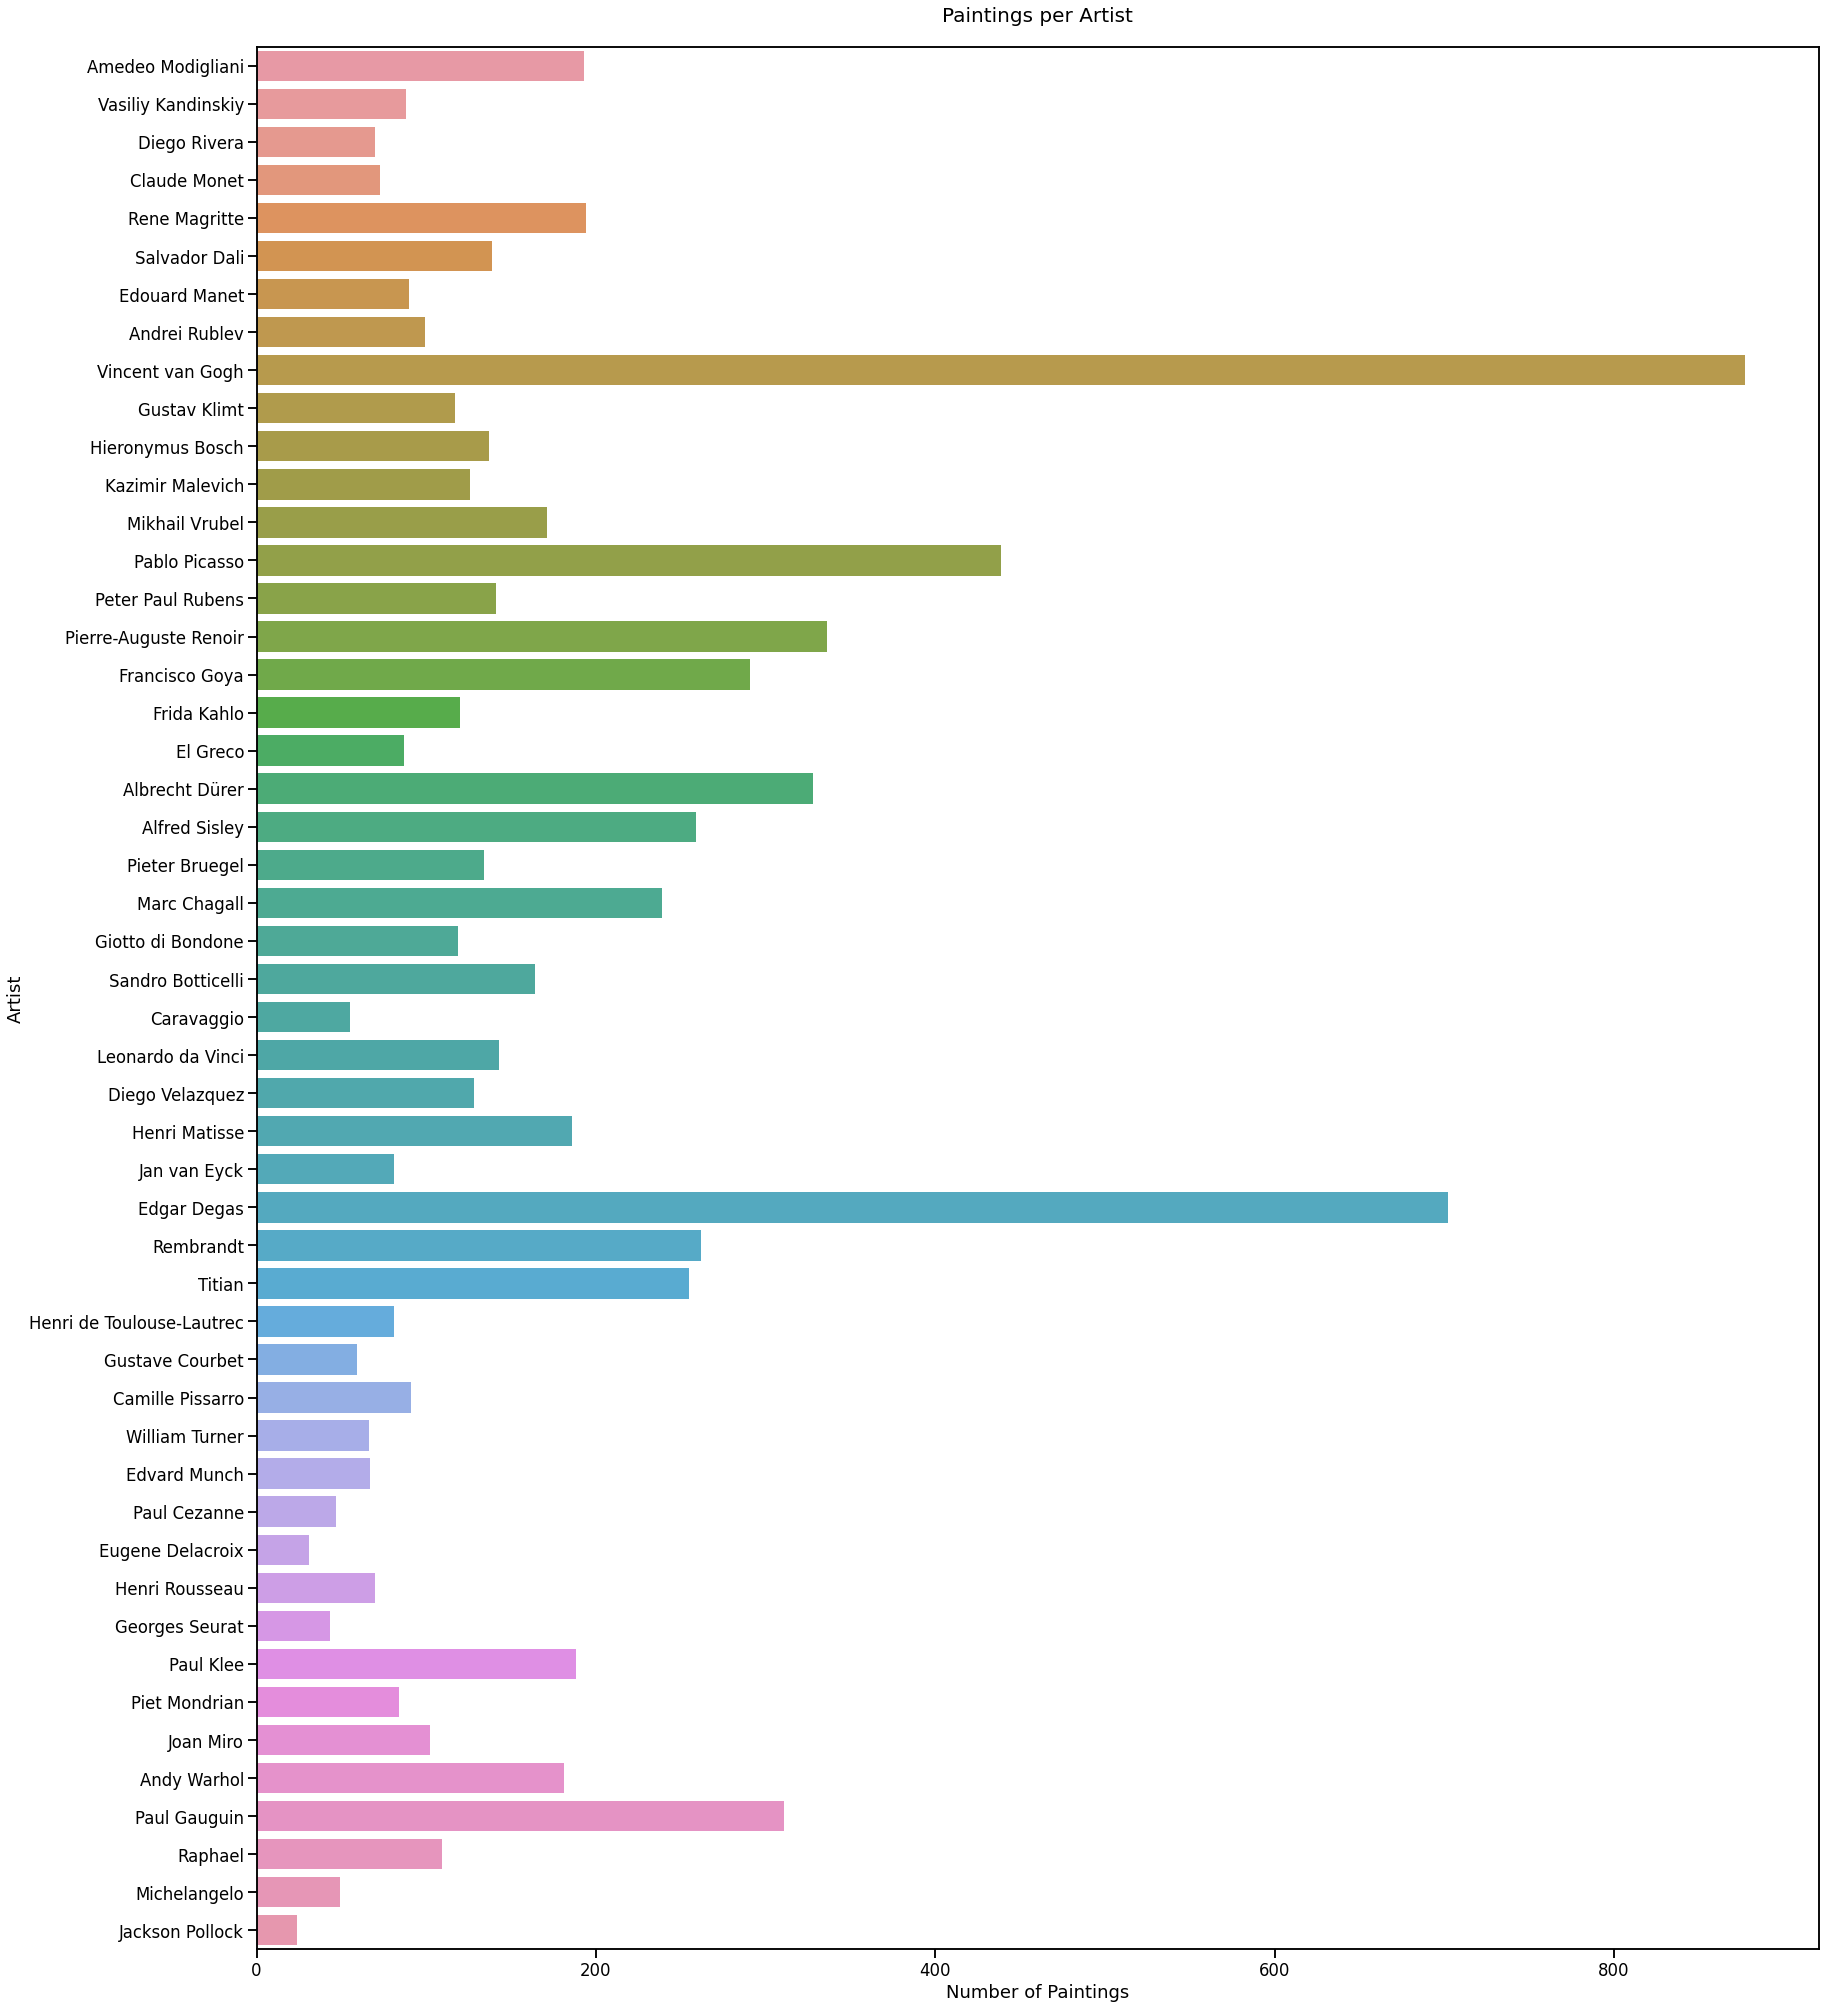

In [220]:
sns.set_context('talk')
plt.figure(figsize=(28,35))
barplot = sns.barplot(x='paintings', y='name', data=artists, orient='h', saturation=0.7)
barplot.axes.set_title('Paintings per Artist', fontsize=20, y=1.01)
barplot.set(xlabel='Number of Paintings', ylabel='Artist');

In [221]:
artists['paintings'].describe()

count     50.000000
mean     168.920000
std      157.451105
min       24.000000
25%       81.000000
50%      123.000000
75%      191.750000
max      877.000000
Name: paintings, dtype: float64

From the output above, we can observe that the average number of paintings per artist in our data set is approximately 169. Consistent to what we have seen in the tables and plot above, the maximum number of paintings an artist in our data set has painted is 877 and the minimum is 24.

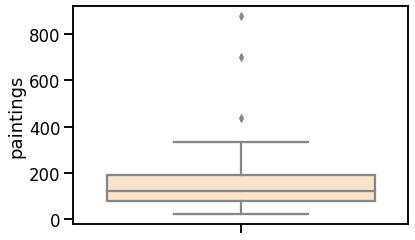

In [222]:
sns.boxplot(y=artists['paintings'], color='bisque');
plt.show()

This boxplot shows the overall distribution of paintings per artist, locating the mean at approximately 169, as we noted before. Moreover, three outliers can be observed. In particular, these values correspond to the three artists that authored more paintings.

### Impact of Genre on Paintings <a name="genre"></a>

In this section we want to explore the impact of genre on the number of paitings (i.e. if the artists belonging to a specific genre ended up painting more art works than the artists belonging to another genre). We start by eliminating blank spaces and dashes so that the names of the genres are easier to handle.

In [261]:
artists['genre'] = artists['genre'].str.replace(" ", "")
artists['genre'] = artists['genre'].str.replace("-", "")

In [262]:
genre = artists['genre'].astype('category').cat.categories.tolist()
genre

['AbstractExpressionism',
 'Baroque',
 'ByzantineArt',
 'Cubism',
 'EarlyRenaissance',
 'Expressionism',
 'Expressionism,Abstractionism',
 'Expressionism,Abstractionism,Surrealism',
 'HighRenaissance',
 'HighRenaissance,Mannerism',
 'Impressionism',
 'Impressionism,PostImpressionism',
 'Mannerism',
 'Neoplasticism',
 'NorthernRenaissance',
 'PopArt',
 'PostImpressionism',
 'Primitivism',
 'Primitivism,Surrealism',
 'ProtoRenaissance',
 'Realism',
 'Realism,Impressionism',
 'Romanticism',
 'SocialRealism,Muralism',
 'Suprematism',
 'Surrealism',
 'Surrealism,Impressionism',
 'Symbolism',
 'Symbolism,ArtNouveau',
 'Symbolism,Expressionism',
 'Symbolism,PostImpressionism']

As we can observe, some artists belong to more than one genre. By creating one binary variable for each existing genre we will be able to take this into account and obtain more precise insights when proceeding with the analysis. 

In [263]:
newdata = pd.get_dummies(artists, columns=['genre'])
newdata['genre_Abstractionism'] = 0
newdata['genre_SocialRealism'] = 0
newdata['genre_Muralism'] = 0
newdata['genre_Symbolism'] = 0
newdata['genre_ArtNouveau'] = 0

In [264]:
for i in range(0, len(artists)):
    if newdata['genre_Expressionism,Abstractionism'][i] == 1:
        newdata['genre_Expressionism'][i] == 1
        newdata['genre_Abstractionism'][i] == 1
    if newdata['genre_Expressionism,Abstractionism,Surrealism'][i] == 1:
        newdata['genre_Expressionism'][i] == 1
        newdata['genre_Abstractionism'][i] == 1
        newdata['genre_Surrealism'][i] == 1
    if newdata['genre_HighRenaissance,Mannerism'][i] == 1:
        newdata['genre_HighRenaissance'][i] == 1
        newdata['genre_Mannerism'][i] == 1
    if newdata['genre_Impressionism,PostImpressionism'][i] == 1:
        newdata['genre_Impressionism'][i] == 1
        newdata['genre_PostImpressionism'][i] == 1
    if newdata['genre_SocialRealism,Muralism'][i] == 1:
        newdata['genre_SocialRealism'][i] == 1
        newdata['genre_Muralism'][i] == 1
    if newdata['genre_Surrealism,Impressionism'][i] == 1:
        newdata['genre_Surrealism'][i] == 1
        newdata['genre_Impressionism'][i] == 1
    if newdata['genre_Realism,Impressionism'][i] == 1:
        newdata['genre_Realism'][i] == 1
        newdata['genre_Impressionism'][i] == 1
    if newdata['genre_Symbolism,ArtNouveau'][i] == 1:
        newdata['genre_Symbolism'][i] == 1
        newdata['genre_ArtNouveau'][i] == 1
    if newdata['genre_Primitivism,Surrealism'][i] == 1:
        newdata['genre_Primitivism'][i] == 1
        newdata['genre_Surrealism'][i] == 1
    if newdata['genre_Symbolism,Expressionism'][i] == 1:
        newdata['genre_Symbolism'][i] == 1
        newdata['genre_Expressionism'][i] == 1
    if newdata['genre_Symbolism,PostImpressionism'][i] == 1:
        newdata['genre_Symbolism'][i] == 1
        newdata['genre_PostImpressionism'][i] == 1
newdata = newdata.drop(['genre_Expressionism,Abstractionism', 'genre_Expressionism,Abstractionism,Surrealism', 
                        'genre_HighRenaissance,Mannerism', 'genre_Impressionism,PostImpressionism', 
                        'genre_SocialRealism,Muralism', 'genre_Surrealism,Impressionism', 
                        'genre_Realism,Impressionism', 'genre_Symbolism,ArtNouveau', 
                        'genre_Primitivism,Surrealism', 'genre_Symbolism,Expressionism', 
                        'genre_Symbolism,PostImpressionism'], axis=1)

In [265]:
newdata.columns

Index(['id', 'name', 'years', 'nationality', 'bio', 'wikipedia', 'paintings',
       'genre_AbstractExpressionism', 'genre_Baroque', 'genre_ByzantineArt',
       'genre_Cubism', 'genre_EarlyRenaissance', 'genre_Expressionism',
       'genre_HighRenaissance', 'genre_Impressionism', 'genre_Mannerism',
       'genre_Neoplasticism', 'genre_NorthernRenaissance', 'genre_PopArt',
       'genre_PostImpressionism', 'genre_Primitivism',
       'genre_ProtoRenaissance', 'genre_Realism', 'genre_Romanticism',
       'genre_Suprematism', 'genre_Surrealism', 'genre_Symbolism',
       'genre_Abstractionism', 'genre_SocialRealism', 'genre_Muralism',
       'genre_ArtNouveau'],
      dtype='object')

With our data ready we can now start running and testing regressions. As we are trying to model the number of paintings, it makes sense to use a **Poisson model** for count data. Hence, we proceed with a GLM (generalized linear model) belonging to the Poisson family:

In [266]:
reg = 'paintings ~ genre_Symbolism + genre_Abstractionism + genre_ArtNouveau + genre_Muralism + genre_SocialRealism + genre_AbstractExpressionism + genre_Baroque + genre_ByzantineArt + genre_Cubism + genre_EarlyRenaissance + genre_Expressionism + genre_HighRenaissance + genre_Impressionism + genre_Mannerism + genre_Neoplasticism + genre_NorthernRenaissance + genre_PopArt + genre_PostImpressionism + genre_Primitivism + genre_ProtoRenaissance + genre_Realism + genre_Romanticism + genre_Suprematism + genre_Surrealism'   

model = smf.glm(formula = reg, data = newdata, family = sm.families.Poisson()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       30
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1895.9
Date:                Mon, 14 Sep 2020   Deviance:                       3457.6
Time:                        14:24:45   Pearson chi2:                 3.80e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       5.0096      0.023    221.105      0.000       4.965       5.054
genre_Symbolism               4.69e-16   3.01e-17     15.586      0.000     4.1e-16    5.28e-16
genre_Abstractionism        -5.808e-16   4.31e-17    -13.466      0.000   -6.65e-16   -4.96e-16
genre_ArtNouveau            -4.077e-17   3.23e-17     -1.262      0.207   -1.04e-16    2.26e-17
genre_Muralism              -1.074e-16   3.68e-17     -2.920      0.003    -1.8e-16   -3.53e-17
genre_SocialRealism          2.367e-16   3.73e-17      6.338      0.000    1.63e-16     3.1e-16
genre_AbstractExpressionism    -1.8316      0.205     -8.918      0.000      -2.234      -1.429
genre_Baroque                  -0.0226      0.047     -0.479      0.632      -0.115       0.070
genre_ByzantineArt             -0.4145      0.103     -4.023      0.000      -0.616      -0.213
genre_Cubism                    1.0749      0.053     20.345      0.000       0.971       1.178
genre_EarlyRenaissance          0.0903      0.081      1.110      0.267      -0.069       0.250
genre_Expressionism             0.2531      0.075      3.354      0.001       0.105       0.401
genre_HighRenaissance          -0.4011      0.062     -6.477      0.000      -0.522      -0.280
genre_Impressionism             0.8267      0.035     23.445      0.000       0.758       0.896
genre_Mannerism                -0.5437      0.110     -4.962      0.000      -0.758      -0.329
genre_Neoplasticism            -0.5788      0.111     -5.194      0.000      -0.797      -0.360
genre_NorthernRenaissance       0.1262      0.045      2.833      0.005       0.039       0.213
genre_PopArt                    0.1889      0.078      2.431      0.015       0.037       0.341
genre_PostImpressionism         0.5587      0.038     14.585      0.000       0.484       0.634
genre_Primitivism               0.0306      0.061      0.499      0.617      -0.089       0.151
genre_ProtoRenaissance         -0.2305      0.094     -2.441      0.015      -0.416      -0.045
genre_Realism                  -0.9321      0.132     -7.053      0.000      -1.191      -0.673
genre_Romanticism              -0.1472      0.056     -2.648      0.008      -0.256      -0.038
genre_Suprematism              -0.1733      0.092     -1.886      0.059      -0.353       0.007
genre_Surrealism               -0.2180      0.068     -3.192      0.001      -0.352      -0.084
===============================================================================================
"""

In [267]:
model.pearson_chi2/model.df_resid

126.76472719595672

The ratio we just computed shows the model presents overdispersion, as it is larger than 1. In other words, the variance does not equal the mean (what we would expect with data being Poisson-distributed) but rather too much variability. When this is the case, one can try to model a **Negative Binomial model**, which is a generalization of the Poisson regression but without the restrictive assumption that the variance is equal to the mean. 

In [268]:
model = smf.glm(formula = reg, data = newdata, family = sm.families.NegativeBinomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       30
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.51
Date:                Mon, 14 Sep 2020   Deviance:                       18.185
Time:                        14:24:46   Pearson chi2:                     17.8
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       5.0096      0.278     18.002      0.000       4.464       5.555
genre_Symbolism             -2.978e-17   4.69e-16     -0.064      0.949   -9.48e-16    8.89e-16
genre_Abstractionism         1.149e-16   5.71e-16      0.201      0.841      -1e-15    1.23e-15
genre_ArtNouveau             3.957e-16   6.34e-16      0.624      0.533   -8.47e-16    1.64e-15
genre_Muralism               1.407e-16   2.94e-16      0.479      0.632   -4.35e-16    7.16e-16
genre_SocialRealism         -4.402e-16   5.38e-16     -0.818      0.413   -1.49e-15    6.14e-16
genre_AbstractExpressionism    -1.8316      1.058     -1.731      0.083      -3.905       0.242
genre_Baroque                  -0.0226      0.574     -0.039      0.969      -1.147       1.102
genre_ByzantineArt             -0.4145      1.043     -0.397      0.691      -2.458       1.629
genre_Cubism                    1.0749      1.039      1.034      0.301      -0.962       3.111
genre_EarlyRenaissance          0.0903      1.041      0.087      0.931      -1.950       2.130
genre_Expressionism             0.2531      1.040      0.243      0.808      -1.786       2.292
genre_HighRenaissance          -0.4011      0.643     -0.623      0.533      -1.662       0.860
genre_Impressionism             0.8267      0.573      1.443      0.149      -0.296       1.949
genre_Mannerism                -0.5437      1.044     -0.521      0.602      -2.589       1.502
genre_Neoplasticism            -0.5788      1.044     -0.555      0.579      -2.624       1.467
genre_NorthernRenaissance       0.1262      0.574      0.220      0.826      -0.998       1.250
genre_PopArt                    0.1889      1.041      0.182      0.856      -1.851       2.229
genre_PostImpressionism         0.5587      0.573      0.975      0.330      -0.564       1.682
genre_Primitivism               0.0306      0.762      0.040      0.968      -1.463       1.524
genre_ProtoRenaissance         -0.2305      1.042     -0.221      0.825      -2.273       1.812
genre_Realism                  -0.9321      1.046     -0.891      0.373      -2.982       1.118
genre_Romanticism              -0.1472      0.643     -0.229      0.819      -1.407       1.113
genre_Suprematism              -0.1733      1.042     -0.166      0.868      -2.215       1.869
genre_Surrealism               -0.2180      0.763     -0.286      0.775      -1.713       1.277
===============================================================================================
"""

In [269]:
pred_val = model.fittedvalues.copy()
obs_val = newdata['paintings'].values.copy()
sqrt(mean_squared_error(obs_val, pred_val))

134.0887784746379

Comparing both log-likelihoods, we can see that the Negative Binomial model performs better than the Poisson model. However, the RMSE (root mean squared error) corresponding to the latter regression model is too high. 

One may say that such disappointing results may be because we are ignoring the fact that some artists belonged to more than one genre. By not including interaction terms in our regression we may be losing a lot of information. We now model a Poisson model including those interaction terms:

In [270]:
reg = 'paintings ~ genre_Symbolism*genre_PostImpressionism + genre_HighRenaissance*genre_Mannerism + genre_Symbolism*genre_Expressionism + genre_Impressionism*genre_PostImpressionism + genre_Primitivism*genre_Surrealism + genre_Symbolism*genre_ArtNouveau + genre_Realism*genre_Impressionism + genre_Expressionism*genre_Abstractionism + genre_Expressionism*genre_Surrealism + genre_SocialRealism*genre_Muralism + genre_Surrealism*genre_Impressionism + genre_AbstractExpressionism + genre_Baroque + genre_ByzantineArt + genre_Cubism + genre_EarlyRenaissance + genre_Expressionism + genre_HighRenaissance + genre_Impressionism + genre_Mannerism + genre_Neoplasticism + genre_NorthernRenaissance + genre_PopArt + genre_PostImpressionism + genre_Primitivism + genre_ProtoRenaissance + genre_Realism + genre_Romanticism + genre_Suprematism + genre_Surrealism'   

model = smf.glm(formula = reg, data = newdata, family = sm.families.Poisson()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       30
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1895.9
Date:                Mon, 14 Sep 2020   Deviance:                       3457.6
Time:                        14:24:47   Pearson chi2:                 3.80e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       5.0096      0.023    221.105      0.000       4.965       5.054
genre_Symbolism                             -4.006e-16    4.7e-17     -8.523      0.000   -4.93e-16   -3.09e-16
genre_PostImpressionism                         0.5587      0.038     14.585      0.000       0.484       0.634
genre_Symbolism:genre_PostImpressionism      -8.22e-16   8.66e-17     -9.495      0.000   -9.92e-16   -6.52e-16
genre_HighRenaissance                          -0.4011      0.062     -6.477      0.000      -0.522      -0.280
genre_Mannerism                                -0.5437      0.110     -4.962      0.000      -0.758      -0.329
genre_HighRenaissance:genre_Mannerism        4.002e-16    3.5e-17     11.440      0.000    3.32e-16    4.69e-16
genre_Expressionism                             0.2531      0.075      3.354      0.001       0.105       0.401
genre_Symbolism:genre_Expressionism         -4.986e-16   5.11e-17     -9.757      0.000   -5.99e-16   -3.98e-16
genre_Impressionism                             0.8267      0.035     23.445      0.000       0.758       0.896
genre_Impressionism:genre_PostImpressionism -4.625e-16   4.98e-17     -9.279      0.000    -5.6e-16   -3.65e-16
genre_Primitivism                               0.0306      0.061      0.499      0.617      -0.089       0.151
genre_Surrealism                               -0.2180      0.068     -3.192      0.001      -0.352      -0.084
genre_Primitivism:genre_Surrealism           1.157e-17   2.47e-17      0.469      0.639   -3.68e-17    5.99e-17
genre_ArtNouveau                            -8.256e-18   1.43e-17     -0.576      0.565   -3.64e-17    1.98e-17
genre_Symbolism:genre_ArtNouveau            -3.105e-17   1.82e-17     -1.706      0.088   -6.67e-17    4.63e-18
genre_Realism                                  -0.9321      0.132     -7.053      0.000      -1.191      -0.673
genre_Realism:genre_Impressionism            2.025e-17   2.26e-17      0.897      0.370    -2.4e-17    6.45e-17
genre_Abstractionism                         4.303e-17   2.77e-17      1.555      0.120   -1.12e-17    9.73e-17
genre_Expressionism:genre_Abstractionism    -1.404e-17   7.62e-18     -1.842      0.065    -2.9e-17    8.99e-19
genre_Expressionism:genre_Surrealism                 0          0        nan        nan           0           0
genre_SocialRealism                                  0          0        nan        nan           0           0
genre_Muralism                                       0          0        nan        nan           0           0
genre_SocialRealism:genre_Muralism                   0          0        nan        nan           0           0
genre_Surrealism:genre_Impressionism                 0     

In [271]:
model.pearson_chi2/model.df_resid

126.76472719595658

We can observe that some of the new regressors present multicollinearity, making it impossible to compute their coefficients and evaluate their impact on the total number of paintings. Again, the ratio between the Pearson Chi Squared test value and the residual degrees of freedom shows overdispersion in our data so we model a Negative Binomial model:

In [272]:
model = smf.glm(formula = reg, data = newdata, family = sm.families.NegativeBinomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       30
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.51
Date:                Mon, 14 Sep 2020   Deviance:                       18.185
Time:                        14:24:47   Pearson chi2:                     17.8
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       5.0096      0.278     18.002      0.000       4.464       5.555
genre_Symbolism                              6.756e-16    7.9e-16      0.855      0.392   -8.73e-16    2.22e-15
genre_PostImpressionism                         0.5587      0.573      0.975      0.330      -0.564       1.682
genre_Symbolism:genre_PostImpressionism      2.764e-17   5.64e-16      0.049      0.961   -1.08e-15    1.13e-15
genre_HighRenaissance                          -0.4011      0.643     -0.623      0.533      -1.662       0.860
genre_Mannerism                                -0.5437      1.044     -0.521      0.602      -2.589       1.502
genre_HighRenaissance:genre_Mannerism       -6.737e-16   3.48e-16     -1.937      0.053   -1.36e-15    7.98e-18
genre_Expressionism                             0.2531      1.040      0.243      0.808      -1.786       2.292
genre_Symbolism:genre_Expressionism         -5.981e-18   2.85e-16     -0.021      0.983   -5.64e-16    5.52e-16
genre_Impressionism                             0.8267      0.573      1.443      0.149      -0.296       1.949
genre_Impressionism:genre_PostImpressionism  1.548e-16   2.83e-16      0.547      0.585      -4e-16     7.1e-16
genre_Primitivism                               0.0306      0.762      0.040      0.968      -1.463       1.524
genre_Surrealism                               -0.2180      0.763     -0.286      0.775      -1.713       1.277
genre_Primitivism:genre_Surrealism          -1.883e-16   2.49e-16     -0.757      0.449   -6.76e-16    2.99e-16
genre_ArtNouveau                             5.673e-17    3.1e-16      0.183      0.855   -5.52e-16    6.65e-16
genre_Symbolism:genre_ArtNouveau            -1.716e-17   1.63e-16     -0.105      0.916   -3.37e-16    3.03e-16
genre_Realism                                  -0.9321      1.046     -0.891      0.373      -2.982       1.118
genre_Realism:genre_Impressionism            7.343e-17   2.01e-16      0.365      0.715   -3.21e-16    4.68e-16
genre_Abstractionism                        -9.233e-17   1.77e-16     -0.523      0.601   -4.38e-16    2.54e-16
genre_Expressionism:genre_Abstractionism    -8.178e-18   1.59e-16     -0.051      0.959    -3.2e-16    3.04e-16
genre_Expressionism:genre_Surrealism                 0          0        nan        nan           0           0
genre_SocialRealism                                  0          0        nan        nan           0           0
genre_Muralism                                       0          0        nan        nan           0           0
genre_SocialRealism:genre_Muralism                   0          0        nan        nan           0           0
genre_Surrealism:genre_Impressionism                 0     

In [273]:
pred_val = model.fittedvalues.copy()
obs_val = newdata['paintings'].values.copy()
sqrt(mean_squared_error(obs_val, pred_val))

134.08877847463788

The above Negative Binomial model also shows multicollinearity among some of the new regressors that try to capture the interaction between two genres. In addition, the RMSE takes a very large value.

Looking at all four models we can argue that belonging to one genre or another (or even multiple of them) does not have a statistically significant impact on the number of paintings an artist authors and maybe more information would be useful to extract reliable conclusions from the data.

### Impact of Nationality on Paintings <a name="nationality"></a>

We are now interested in knowing the impact of nationality on the number of paitings (i.e. if artists of a given nationality ended up painting more art works than artists of another nationality). 

In [274]:
nationality = artists['nationality'].astype('category').cat.categories.tolist()
nationality 

['American',
 'Austrian',
 'Belgian',
 'British',
 'Dutch',
 'Flemish',
 'French',
 'French,British',
 'French,Jewish,Belarusian',
 'German',
 'German,Swiss',
 'Italian',
 'Mexican',
 'Norwegian',
 'Russian',
 'Spanish',
 'Spanish,Greek']

Similarly to what happened with some artists belonging to different genres, now we encounter that some artists had more than two nationalities. We will fix this issue the same way we fixed it for the genres:

In [275]:
newdata = pd.get_dummies(artists, columns=['nationality'])
newdata['nationality_Jewish'] = 0
newdata['nationality_Belarussian'] = 0
newdata['nationality_Swiss'] = 0
newdata['nationality_Greek'] = 0

In [276]:
for i in range(0, len(newdata)):
    if newdata['nationality_French,British'][i] == 1:
        newdata['nationality_French'][i] == 1
        newdata['nationality_British'][i] == 1
    if newdata['nationality_French,Jewish,Belarusian'][i] == 1:
        newdata['nationality_French'][i] == 1
        newdata['nationality_Jewish'][i] == 1
        newdata['nationality_Belarussian'][i] == 1
    if newdata['nationality_German,Swiss'][i] == 1:
        newdata['nationality_German'][i] == 1
        newdata['nationality_Swiss'][i] == 1
    if newdata['nationality_Spanish,Greek'][i] == 1:
        newdata['nationality_Spanish'][i] == 1
        newdata['nationality_Greek'][i] == 1
newdata = newdata.drop(['nationality_French,British', 'nationality_French,Jewish,Belarusian',
                        'nationality_German,Swiss', 'nationality_Spanish,Greek'], axis=1)

In [277]:
newdata.columns

Index(['id', 'name', 'years', 'genre', 'bio', 'wikipedia', 'paintings',
       'nationality_American', 'nationality_Austrian', 'nationality_Belgian',
       'nationality_British', 'nationality_Dutch', 'nationality_Flemish',
       'nationality_French', 'nationality_German', 'nationality_Italian',
       'nationality_Mexican', 'nationality_Norwegian', 'nationality_Russian',
       'nationality_Spanish', 'nationality_Jewish', 'nationality_Belarussian',
       'nationality_Swiss', 'nationality_Greek'],
      dtype='object')

As in the previous section, our dependent variable (number of paintings) is a count variable. Consequently, we start by running a Poisson regression and checking for overdispersion:

In [278]:
reg = 'paintings ~ nationality_American + nationality_Austrian + nationality_Belgian + nationality_British + nationality_Dutch + nationality_Flemish + nationality_French + nationality_German + nationality_Italian + nationality_Mexican + nationality_Norwegian + nationality_Russian + nationality_Spanish + nationality_Jewish + nationality_Belarussian + nationality_Swiss + nationality_Greek'

model = smf.glm(formula = reg, data = newdata, family = sm.families.Poisson()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       36
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2126.1
Date:                Mon, 14 Sep 2020   Deviance:                       3918.1
Time:                        14:24:49   Pearson chi2:                 4.73e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.2640      0.036    146.354      0.000       5.193       5.334
nationality_American       -0.6341      0.079     -8.072      0.000      -0.788      -0.480
nationality_Austrian       -0.5018      0.099     -5.059      0.000      -0.696      -0.307
nationality_Belgian         0.0039      0.080      0.048      0.962      -0.154       0.161
nationality_British        -1.0743      0.128     -8.378      0.000      -1.326      -0.823
nationality_Dutch           0.5650      0.045     12.542      0.000       0.477       0.653
nationality_Flemish        -0.4877      0.064     -7.614      0.000      -0.613      -0.362
nationality_French         -0.1698      0.042     -4.040      0.000      -0.252      -0.087
nationality_German          0.5290      0.066      8.028      0.000       0.400       0.658
nationality_Italian        -0.3522      0.047     -7.487      0.000      -0.444      -0.260
nationality_Mexican        -0.7101      0.081     -8.770      0.000      -0.869      -0.551
nationality_Norwegian      -1.0593      0.127     -8.318      0.000      -1.309      -0.810
nationality_Russian        -0.4682      0.058     -8.077      0.000      -0.582      -0.355
nationality_Spanish         0.1287      0.047      2.742      0.006       0.037       0.221
nationality_Jewish               0          0        nan        nan           0           0
nationality_Belarussian          0          0        nan        nan           0           0
nationality_Swiss                0          0        nan        nan           0           0
nationality_Greek                0          0        nan        nan           0           0
===========================================================================================
"""

In [279]:
model.pearson_chi2/model.df_resid

131.40897518621807

The above ratio shows this model presents too much variability so our data is not Poisson-distributed so maybe a Negative Binomial model may be more adequate:

In [280]:
model = smf.glm(formula = reg, data = newdata, family = sm.families.NegativeBinomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -303.12
Date:                Mon, 14 Sep 2020   Deviance:                       21.414
Time:                        14:24:50   Pearson chi2:                     25.3
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.2640      0.501     10.501      0.000       4.281       6.246
nationality_American       -0.6341      0.870     -0.729      0.466      -2.338       1.070
nationality_Austrian       -0.5018      1.122     -0.447      0.655      -2.702       1.698
nationality_Belgian         0.0039      1.121      0.003      0.997      -2.193       2.201
nationality_British        -1.0743      1.125     -0.955      0.340      -3.280       1.131
nationality_Dutch           0.5650      0.709      0.797      0.425      -0.824       1.954
nationality_Flemish        -0.4877      0.766     -0.636      0.525      -1.990       1.015
nationality_French         -0.1698      0.573     -0.296      0.767      -1.293       0.954
nationality_German          0.5290      1.120      0.472      0.637      -1.666       2.724
nationality_Italian        -0.3522      0.614     -0.574      0.566      -1.556       0.852
nationality_Mexican        -0.7101      0.870     -0.816      0.414      -2.415       0.995
nationality_Norwegian      -1.0593      1.125     -0.941      0.347      -3.265       1.146
nationality_Russian        -0.4682      0.709     -0.660      0.509      -1.859       0.922
nationality_Spanish         0.1287      0.672      0.191      0.848      -1.189       1.447
nationality_Jewish               0          0        nan        nan           0           0
nationality_Belarussian          0          0        nan        nan           0           0
nationality_Swiss                0          0        nan        nan           0           0
nationality_Greek                0          0        nan        nan           0           0
===========================================================================================
"""

In [281]:
pred_val = model.fittedvalues.copy()
obs_val = newdata['paintings'].values.copy()
sqrt(mean_squared_error(obs_val, pred_val))

140.50355972313224

After running a Negative Binomial model, we can observe that some regressors present multicollinearity (as they also did in the previous Poisson model) and that the RMSE is too high, which indicates that this is not a very good model. 

Again, we have not taken into account that some artists hold more than one nationality. To take this into account in the following models, we include interaction terms.

In [282]:
reg = 'paintings ~ nationality_Greek*nationality_Spanish + nationality_German*nationality_Swiss + nationality_Jewish*nationality_French*nationality_Belarussian + nationality_French*nationality_British + nationality_American + nationality_Austrian + nationality_Belgian + nationality_British + nationality_Dutch + nationality_Flemish + nationality_French + nationality_German + nationality_Italian + nationality_Mexican + nationality_Norwegian + nationality_Russian + nationality_Spanish + nationality_Jewish + nationality_Belarussian + nationality_Swiss + nationality_Greek'

model = smf.glm(formula = reg, data = newdata, family = sm.families.Poisson()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       36
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2126.1
Date:                Mon, 14 Sep 2020   Deviance:                       3918.1
Time:                        14:24:51   Pearson chi2:                 4.73e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         5.2640      0.036    146.354      0.000       5.193       5.334
nationality_Greek                                              -6.97e-16   6.09e-17    -11.450      0.000   -8.16e-16   -5.78e-16
nationality_Spanish                                               0.1287      0.047      2.742      0.006       0.037       0.221
nationality_Greek:nationality_Spanish                            7.1e-16   4.66e-17     15.244      0.000    6.19e-16    8.01e-16
nationality_German                                                0.5290      0.066      8.028      0.000       0.400       0.658
nationality_Swiss                                              2.209e-16   2.43e-17      9.101      0.000    1.73e-16    2.68e-16
nationality_German:nationality_Swiss                          -5.971e-16   4.76e-17    -12.539      0.000    -6.9e-16   -5.04e-16
nationality_Jewish                                             2.704e-16   3.04e-17      8.882      0.000    2.11e-16     3.3e-16
nationality_French                                               -0.1698      0.042     -4.040      0.000      -0.252      -0.087
nationality_Jewish:nationality_French                         -8.586e-17    3.1e-17     -2.770      0.006   -1.47e-16   -2.51e-17
nationality_Belarussian                                       -4.962e-16   3.48e-17    -14.245      0.000   -5.64e-16   -4.28e-16
nationality_Jewish:nationality_Belarussian                     1.072e-16   2.45e-17      4.384      0.000    5.93e-17    1.55e-16
nationality_French:nationality_Belarussian                      1.81e-17   2.75e-17      0.658      0.511   -3.58e-17     7.2e-17
nationality_Jewish:nationality_French:nationality_Belarussian  6.807e-17   1.12e-17      6.059      0.000     4.6e-17    9.01e-17
nationality_British                                              -1.0743      0.128     -8.378      0.000      -1.326      -0.823
nationality_French:nationality_British                                 0          0        nan        nan           0           0
nationality_American                                             -0.6341      0.079     -8.072      0.000      -0.788      -0.480
nationality_Austrian                                             -0.5018      0.099     -5.059      0.000      -0.696      -0.307
nationality_Belgian                                               0.0039      0.080      0.048      0.962      -0.154       0.161
nationality_Dutch                                                 0.5650      0.045     12.542      0.000       0.477       0.653
nationality_Flemish                                              -0.4877      0.064     -7.61

In [283]:
model.pearson_chi2/model.df_resid

131.40897518621773

Once again, overdispersion is present in our data. Hence, a Negative Binomial model is run:

In [284]:
model = smf.glm(formula = reg, data = newdata, family = sm.families.NegativeBinomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              paintings   No. Observations:                   50
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -303.12
Date:                Mon, 14 Sep 2020   Deviance:                       21.414
Time:                        14:24:51   Pearson chi2:                     25.3
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         5.2640      0.501     10.501      0.000       4.281       6.246
nationality_Greek                                              1.175e-15      7e-16      1.680      0.093   -1.96e-16    2.55e-15
nationality_Spanish                                               0.1287      0.672      0.191      0.848      -1.189       1.447
nationality_Greek:nationality_Spanish                         -2.273e-17   1.22e-16     -0.186      0.853   -2.62e-16    2.17e-16
nationality_German                                                0.5290      1.120      0.472      0.637      -1.666       2.724
nationality_Swiss                                              -5.36e-16   4.17e-16     -1.285      0.199   -1.35e-15    2.81e-16
nationality_German:nationality_Swiss                          -8.141e-17   3.65e-16     -0.223      0.824   -7.97e-16    6.34e-16
nationality_Jewish                                            -1.488e-16   1.62e-16     -0.918      0.359   -4.66e-16    1.69e-16
nationality_French                                               -0.1698      0.573     -0.296      0.767      -1.293       0.954
nationality_Jewish:nationality_French                          8.265e-17   1.26e-16      0.654      0.513   -1.65e-16     3.3e-16
nationality_Belarussian                                       -4.833e-17   1.66e-16     -0.291      0.771   -3.74e-16    2.78e-16
nationality_Jewish:nationality_Belarussian                     -3.68e-17   1.72e-16     -0.213      0.831   -3.75e-16    3.01e-16
nationality_French:nationality_Belarussian                     5.843e-17   1.28e-16      0.457      0.647   -1.92e-16    3.09e-16
nationality_Jewish:nationality_French:nationality_Belarussian  1.378e-17   2.29e-16      0.060      0.952   -4.35e-16    4.62e-16
nationality_British                                              -1.0743      1.125     -0.955      0.340      -3.280       1.131
nationality_French:nationality_British                                 0          0        nan        nan           0           0
nationality_American                                             -0.6341      0.870     -0.729      0.466      -2.338       1.070
nationality_Austrian                                             -0.5018      1.122     -0.447      0.655      -2.702       1.698
nationality_Belgian                                               0.0039      1.121      0.003      0.997      -2.193       2.201
nationality_Dutch                                                 0.5650      0.709      0.797      0.425      -0.824       1.954
nationality_Flemish                                              -0.4877      0.766     -0.63

In [285]:
pred_val = model.fittedvalues.copy()
obs_val = newdata['paintings'].values.copy()
sqrt(mean_squared_error(obs_val, pred_val))

140.50355972313224

In these two last models, there is a regressor that presents multicollinearity and thus we have not been able to compute its coefficient. Moreover, looking at the high RMSE we can state that this is not a reliable model.

From this section we learn that an artist's nationality has not a significant impact on the amount of paintings this artist authors, maybe more information is needed to draw reliable conclusions.

### Relationship between Nationality and Genre <a name="correlation"></a>

One may expect that artists would belong to different genres according to their nationality. In this section we explore the relationship between these two variables.

In [286]:
nat_gen_df = artists.drop(['id','name','years','paintings','bio','wikipedia'], axis=1)
nat_gen_df['nationality'] = nat_gen_df['nationality'].str.replace(",", ", ")
nat_gen_df['genre'] = nat_gen_df['genre'].str.replace(",", ", ")
classif = nat_gen_df.groupby(['nationality', 'genre']).count()
classif

Empty DataFrame
Columns: []
Index: [(American, AbstractExpressionism), (American, PopArt), (Austrian, Symbolism, ArtNouveau), (Belgian, Surrealism, Impressionism), (British, Romanticism), (Dutch, Baroque), (Dutch, Neoplasticism), (Dutch, NorthernRenaissance), (Dutch, PostImpressionism), (Flemish, Baroque), (Flemish, NorthernRenaissance), (French, Impressionism), (French, Impressionism, PostImpressionism), (French, PostImpressionism), (French, Primitivism), (French, Realism), (French, Realism, Impressionism), (French, Romanticism), (French, Symbolism, PostImpressionism), (French, British, Impressionism), (French, Jewish, Belarusian, Primitivism), (German, NorthernRenaissance), (German, Swiss, Expressionism, Abstractionism, Surrealism), (Italian, Baroque), (Italian, EarlyRenaissance), (Italian, Expressionism), (Italian, HighRenaissance), (Italian, HighRenaissance, Mannerism), (Italian, ProtoRenaissance), (Mexican, Primitivism, Surrealism), (Mexican, SocialRealism, Muralism), (Norwegian, Symbolism, Expressionism), (Russian, ByzantineArt), (Russian, Expressionism, Abstractionism), (Russian, Suprematism), (Russian, Symbolism), (Spanish, Baroque), (Spanish, Cubism), (Spanish, Romanticism), (Spanish, Surrealism), (Spanish, Greek, Mannerism)]

The above table shows the genres corresponding to each nationality but it is not very informative and does not allow us to see if there is some dependence between both variables. We now build a contingency table that collects the number of artists corresponding to a given genre and nationality. To the resulting contingency table we run a Chi-Squared independence test:

In [303]:
contingency_table = pd.crosstab(artists['genre'], artists['nationality'], margins = True)
contingency_table = contingency_table.drop(contingency_table.columns[-1],axis=1) 
# We drop the last column, which counts all nationalities for a given genre

round(st.stats.chi2_contingency(contingency_table)[1],3) # This will print the p-value

0.005

Since the p-value obtained is smaller than 0.05, we reject the null hypothesis of independence at a 5% significance level. Hence, the genre (or genres) to which an artist belongs is not independent from the artist's nationality. In other words, depending on where an artist is from they have more or less chances to belong to a given genre or another.

## Artist Prediction Model <a name="prediction"></a>

WORK IN PROGRESS